In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import geopandas as gpd
from branca.colormap import LinearColormap
from sklearn.preprocessing import StandardScaler  
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder


In [60]:
import zipfile as zf
files = zf.ZipFile("listings.zip", 'r')
files.extractall()
files.close()

In [61]:
#Reading the data 

data = pd.read_csv('listings.csv')
print(data.shape)

(45053, 106)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Columns and the types

data.dtypes


id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [4]:
# Descriptive statistics
data.describe()

id     scrape_id  thumbnail_url  medium_url  xl_picture_url  \
count  4.505300e+04  4.505300e+04            0.0         0.0             0.0   
mean   2.224272e+07  2.019091e+13            NaN         NaN             NaN   
std    1.102304e+07  7.957120e+00            NaN         NaN             NaN   
min    1.090000e+02  2.019091e+13            NaN         NaN             NaN   
25%    1.392280e+07  2.019091e+13            NaN         NaN             NaN   
50%    2.316784e+07  2.019091e+13            NaN         NaN             NaN   
75%    3.195234e+07  2.019091e+13            NaN         NaN             NaN   
max    3.860617e+07  2.019091e+13            NaN         NaN             NaN   

            host_id  host_acceptance_rate  host_listings_count  \
count  4.505300e+04                   0.0         45037.000000   
mean   8.121747e+07                   NaN            18.264849   
std    8.250552e+07                   NaN           117.755692   
min    5.900000e+01                   NaN             0.000000   
25%    1.265900e+07                   NaN             1.000000   
50%    4.731941e+07                   NaN             2.000000   
75%    1.352534e+08                   NaN             6.000000   
max    2.946834e+08                   NaN          1603.000000   

       host_total_listings_count  neighbourhood_group_cleansed  ...  \
count               45037.000000                           0.0  ...   
mean                   18.264849                           NaN  ...   
std                   117.755692                           NaN  ...   
min                     0.000000                           NaN  ...   
25%                     1.000000                           NaN  ...   
50%                     2.000000                           NaN  ...   
75%                     6.000000                           NaN  ...   
max                  1603.000000                           NaN  ...   

       review_scores_cleanliness  review_scores_checkin  \
count               35958.000000           35933.000000   
mean                    9.414678               9.753625   
std                     0.986796               0.745610   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                 35955.000000            35928.000000   
mean                      9.735864                9.688210   
std                       0.770205                0.723178   
min                       2.000000                2.000000   
25%                      10.000000               10.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  calculated_host_listings_count  \
count         35920.000000                    45053.000000   
mean              9.434688                        6.961912   
std               0.925896                       16.563898   
min               2.000000                        1.000000   
25%               9.000000                        1.000000   
50%              10.000000                        2.000000   
75%              10.000000                        5.000000   
max              10.000000                      172.000000   

       calculated_host_listings_count_entire_homes  \
count                                 45053.000000   
mean                                      4.969969   
std                                      15.921579   
min                                       0.000000   
25%                                       0.000000   
50%                                       1.000000   
75%                              

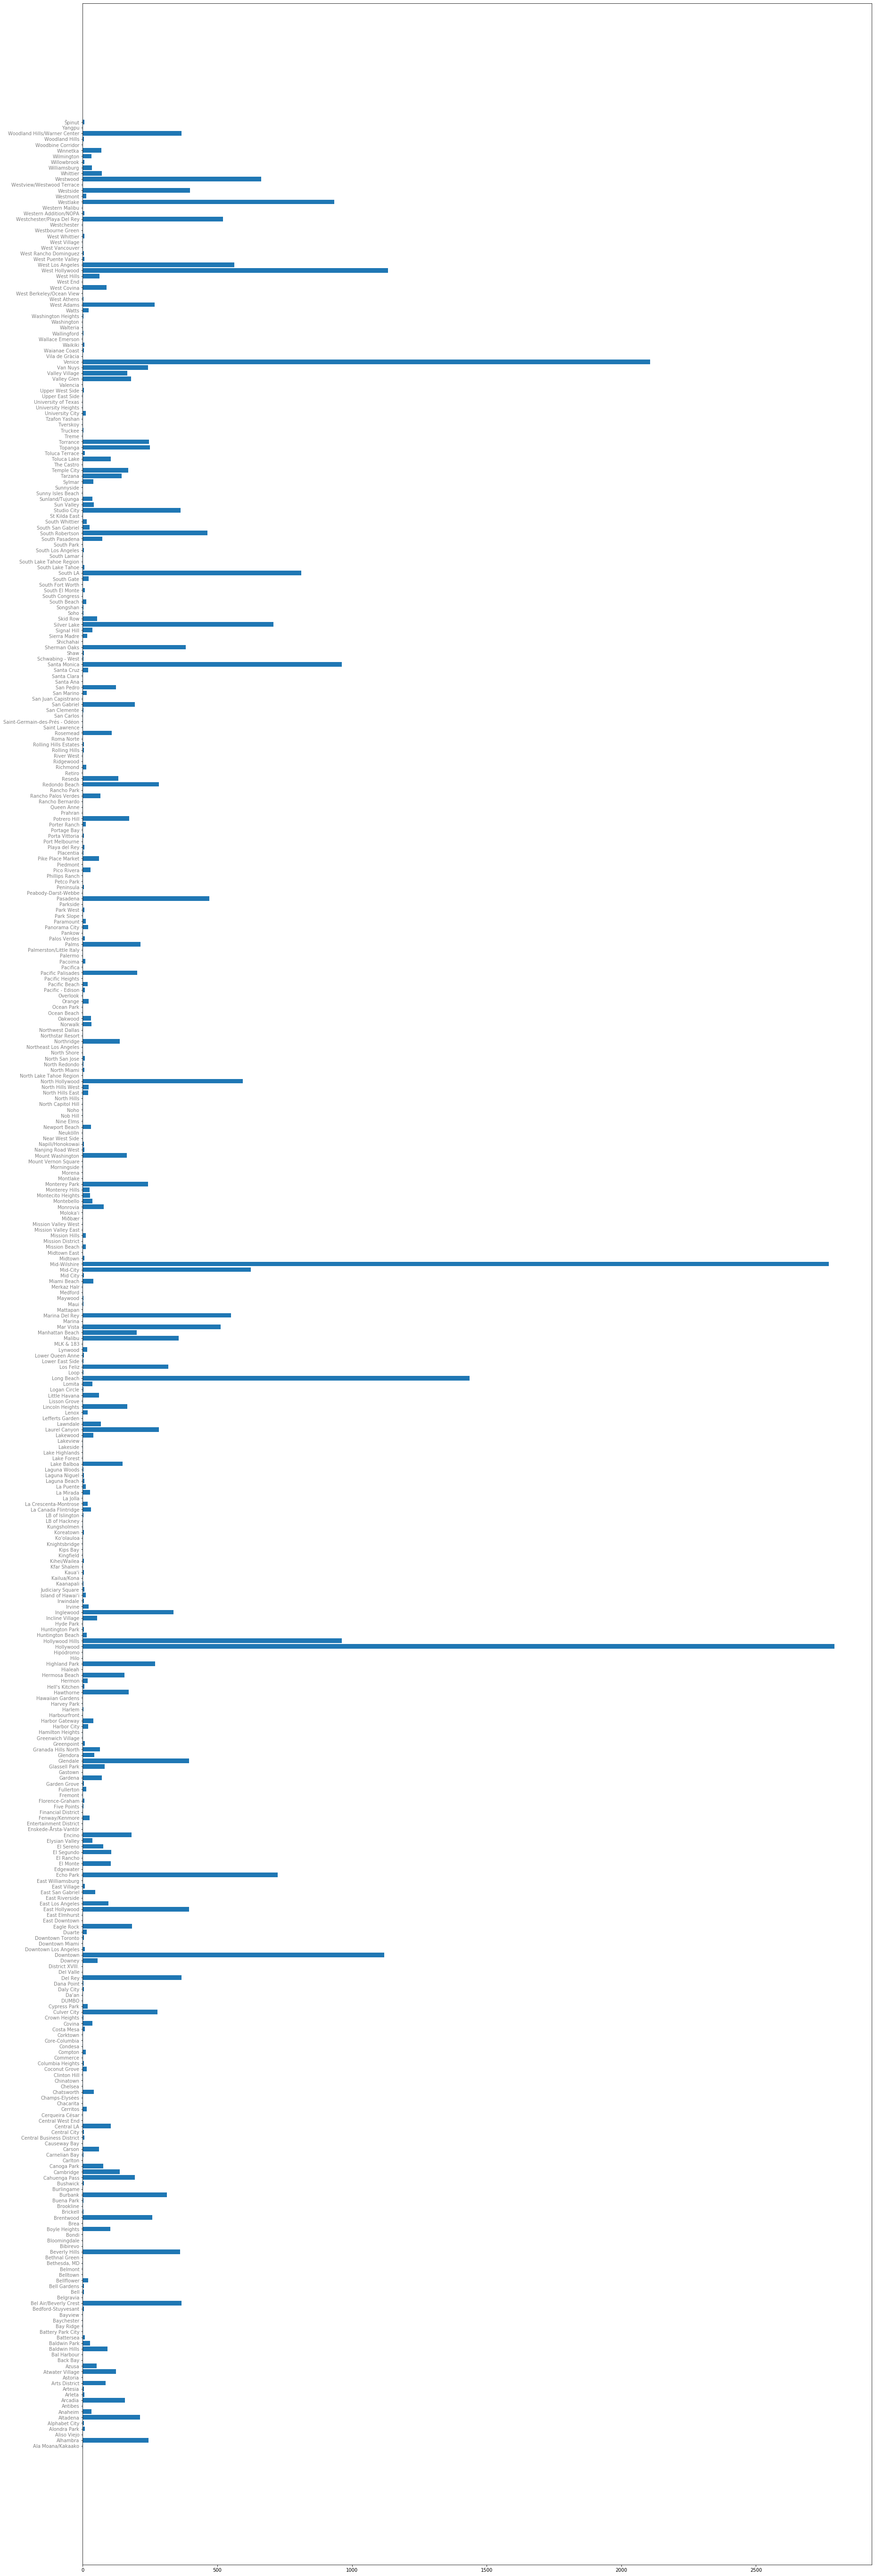

In [5]:
#Number of properties in each neighborhood

properties_per_location = data.groupby(['host_neighbourhood']).size().reset_index(name='counts')
fig = plt.figure(figsize=(30,100))
ax = fig.add_subplot(111)
yvals = range(len(properties_per_location['host_neighbourhood']))
ax.barh(yvals, properties_per_location['counts'], align='center')
plt.yticks(yvals,properties_per_location['host_neighbourhood'],alpha=0.5)

plt.show()



In [6]:
#Add marker clusters of observations to a map 
lats = data['latitude'].tolist()
lons = data['longitude'].tolist()
locations = list(zip(lats, lons))

map1 = folium.Map(location=[34.0522, -118.2437], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

In [7]:
#Display density of Airbnb LA data observations on map

map2 = folium.Map([34.0522, -118.2437], zoom_start=11.5)
HeatMap(data[['latitude','longitude']].dropna(), radius=8).add_to(map2)
display(map2)

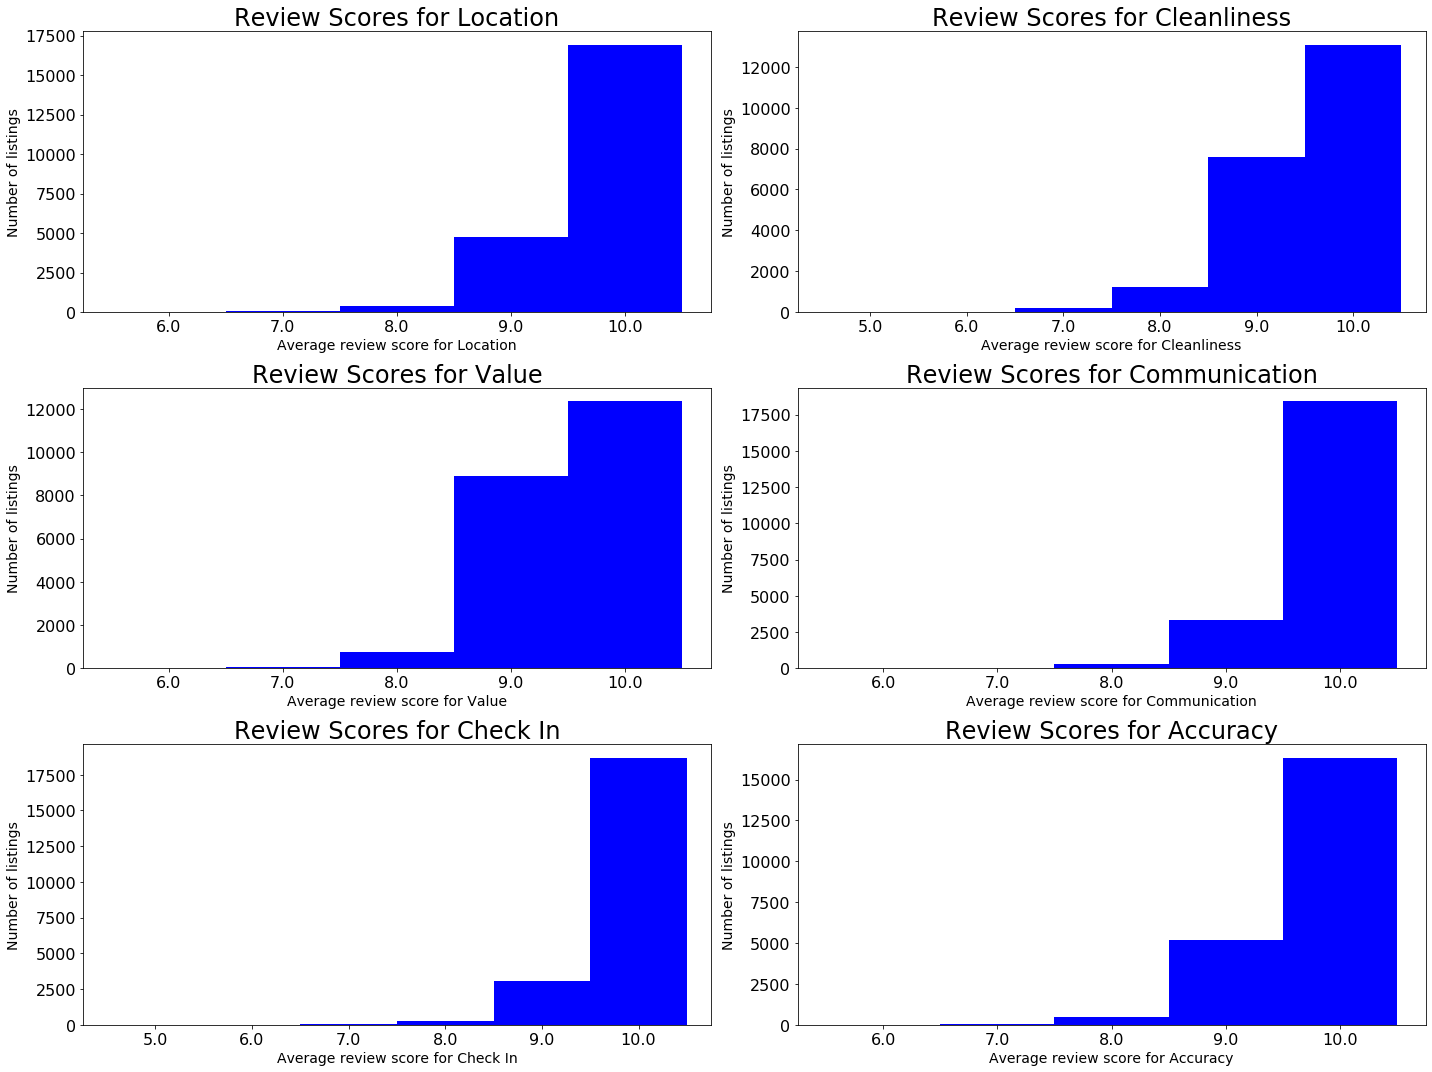

In [8]:
#Compare reviews with number of listings for various categories:
#location, cleanliness, value, arrival, communication, accuracy

listingsLA = data[data['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listingsLA['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Location', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listingsLA['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Cleanliness', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listingsLA['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Value', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listingsLA['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Communication', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listingsLA['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Check In", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Check In', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listingsLA['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Review Scores for Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score for Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

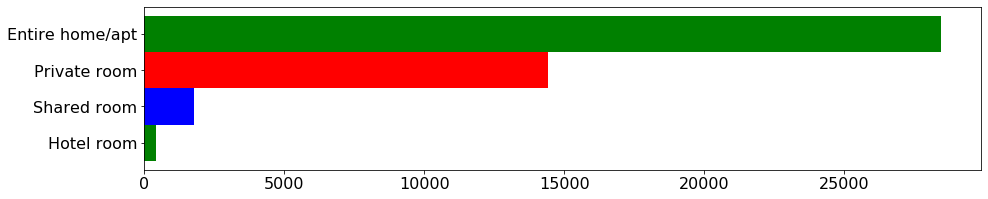

In [9]:
#Display what kinds of room types are most popular/prevalent

freq = data['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

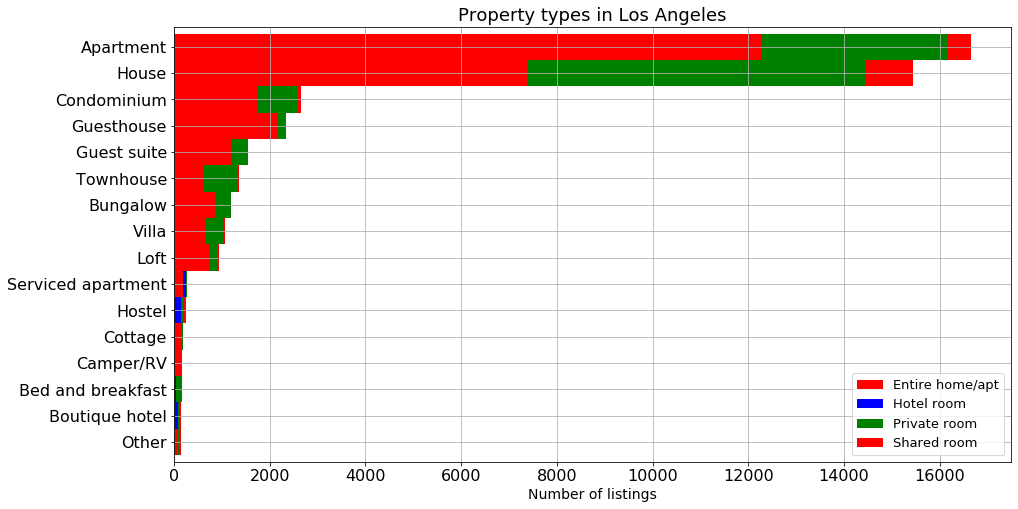

In [10]:
#Display most prevalent property types and whether you receive an entire place to yourself, private room, shared room, etc.

data.property_type.unique()
prop = data.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Los Angeles', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

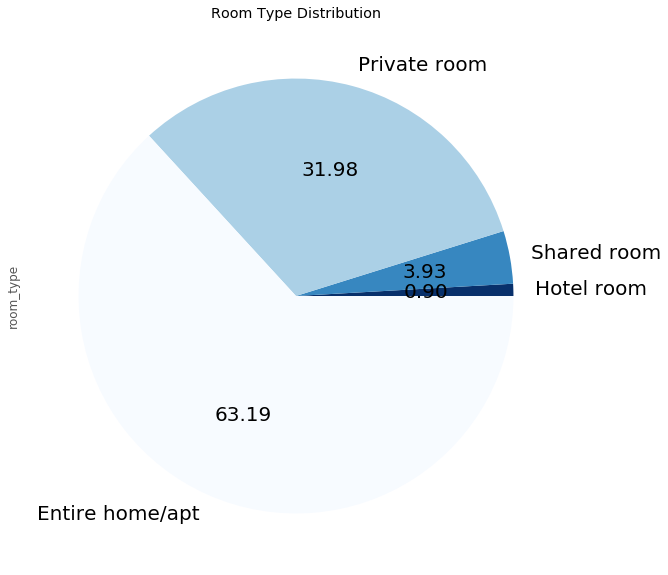

In [11]:
#Display what kinds of room types are most popular/prevalent
roomType_DF=data.groupby('room_type').id.count()
propertytype_DF = data.groupby('property_type').id.count()

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

room = data.room_type
r = Counter(room)

room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']
room_df.plot.pie(y = 'room_type', 
                 colormap = 'Blues_r', 
                 figsize=(10,10), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Room Type Distribution')

In [12]:
#dropping columns 


data = data.drop(columns = ['host_id','listing_url','scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','picture_url',
                    'xl_picture_url','host_url','host_name','host_about','host_acceptance_rate','host_thumbnail_url',
                    'host_picture_url','host_listings_count','host_verifications','host_has_profile_pic','neighbourhood_group_cleansed',
                     'country_code','country','calendar_last_scraped','jurisdiction_names','is_location_exact','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])

data = data.drop(columns= ['name','summary','space','description','neighborhood_overview','notes','transit','access','interaction',
                          'house_rules','host_location','host_neighbourhood','street','neighbourhood_cleansed','city','state','market','smart_location',
                           'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                           'calendar_updated','weekly_price','monthly_price','license','neighbourhood','zipcode',
                           'availability_30', 'availability_60', 'availability_90',
                          'requires_license','instant_bookable','require_guest_profile_picture', 'require_guest_phone_verification','square_feet'])

                                    



data.shape

(45053, 44)

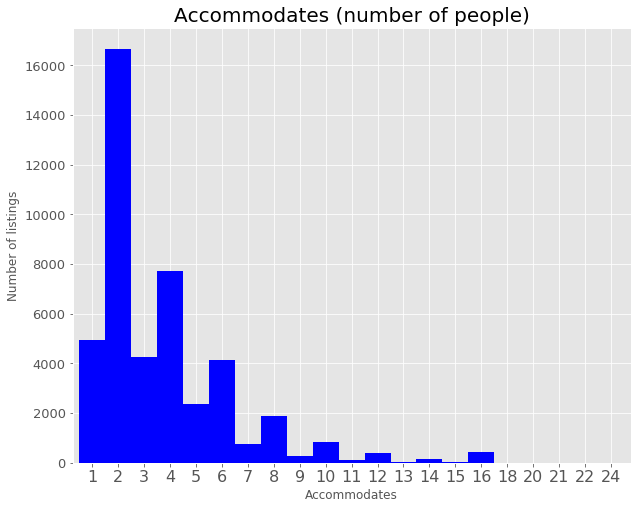

In [13]:
#Explore whether number of listings is related to how many people are accommodated at a time

feq=data['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

In [14]:
data.head()

id  host_since host_response_time host_response_rate host_is_superhost  \
0   109  2008-06-27                NaN                NaN                 f   
1   344  2008-07-11       within a day                50%                 f   
2  2708  2008-09-16     within an hour               100%                 t   
3  2732  2008-09-17     within an hour               100%                 t   
4  2864  2008-09-25                NaN                NaN                 f   

   host_total_listings_count host_identity_verified  latitude  longitude  \
0                        1.0                      t  33.98209 -118.38494   
1                        1.0                      t  34.16562 -118.33458   
2                        2.0                      t  34.09768 -118.34602   
3                        2.0                      f  34.00475 -118.48127   
4                        1.0                      t  33.87619 -118.11397   

  property_type  ... review_scores_communication  review_scores_location  \
0   Condominium  ...                         8.0                    10.0   
1         House  ...                        10.0                    10.0   
2     Apartment  ...                        10.0                    10.0   
3     Apartment  ...                        10.0                    10.0   
4     Apartment  ...                         NaN                     NaN   

   review_scores_value  is_business_travel_ready          cancellation_policy  \
0                  8.0                         f  strict_14_with_grace_period   
1                  9.0                         f                     flexible   
2                 10.0                         f  strict_14_with_grace_period   
3                  9.0                         f  strict_14_with_grace_period   
4                  NaN                         f  strict_14_with_grace_period   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              1                                           1   
2                              2                                           0   
3                              2                                           1   
4                              1                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            2   
3                                            1   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.02  
1                                           0              0.15  
2                                           0              0.33  
3                                           0              0.19  
4                                           0               NaN  

[5 rows x 44 columns]

In [15]:
#PREPROCESSING 

#filling NA values 
data['host_response_time'] = data['host_response_time'].fillna('a few days or more')
data['host_is_superhost'] = data['host_is_superhost'].fillna('f')
data['host_identity_verified'] = data['host_identity_verified'].fillna('f')
data['has_availability'] = data['has_availability'].fillna('f')
data['is_business_travel_ready'] = data['is_business_travel_ready'].fillna('f')
data['host_response_rate'] = data['host_response_rate'].fillna('0%')

                                 
#dropping observations
data = data.dropna(subset=['bathrooms'])
data = data.dropna(subset=['bedrooms'])
data = data.dropna(subset=['beds'])
data = data.dropna(subset=['host_since'])

#one hot encoding for categorical variables and then dropping the existing columns
dummies_host_response_time = pd.get_dummies(data["host_response_time"])
dummies_host_is_superhost = pd.get_dummies(data["host_is_superhost"])
dummies_property_type = pd.get_dummies(data["property_type"])
dummies_room_type = pd.get_dummies(data["room_type"])
dummies_bed_type = pd.get_dummies(data["bed_type"])
dummies_cancellation_policy = pd.get_dummies(data["cancellation_policy"])

data = data.drop(columns = ['host_response_time','host_is_superhost','host_identity_verified',
                            'property_type','property_type','room_type','bed_type','has_availability','cancellation_policy',
                            'is_business_travel_ready']) 


#string and number manipulation
data['amenities'] = data['amenities'].str.count(",") + 1
data['price'] = data['price'].str.replace("$","").str.replace(",","").astype(float)
data['security_deposit'] = data['security_deposit'].str.replace("$","").str.replace(",","").astype(float)
data['cleaning_fee'] = data['cleaning_fee'].str.replace("$","").str.replace(",","").astype(float)
data['extra_people'] = data['extra_people'].str.replace("$","").str.replace(",","").astype(float)
data['host_response_rate'] = data['host_response_rate'].str.replace("%","").astype(float)


data['security_deposit'] = data['security_deposit'].fillna(0)
data['cleaning_fee'] = data['cleaning_fee'].fillna(0)




In [16]:
#data manipulation

data['first_review'] = data['first_review'].fillna(data['host_since'])
data['last_review'] = data['last_review'].fillna(data['host_since'])
data['host_since']= pd.to_datetime(data['host_since']) 
data['host_since'] = (pd.to_datetime('today')-data['host_since']).dt.days
data['first_review']= pd.to_datetime(data['first_review']) 
data['first_review'] = (pd.to_datetime('today')-data['first_review']).dt.days
data['last_review']= pd.to_datetime(data['last_review']) 
data['last_review'] = (pd.to_datetime('today')-data['last_review']).dt.days



In [17]:
#finding minimum values of variables to fill in place of NA
min_accuracy_score = data['review_scores_accuracy'].min()
min_rating_score = data['review_scores_rating'].min()
min_cleanliness_score = data['review_scores_cleanliness'].min()
min_checkin_score = data['review_scores_checkin'].min()
min_communication_score = data['review_scores_communication'].min()
min_location_score = data['review_scores_location'].min()
min_value_score = data['review_scores_value'].min()
min_rpm_score = data['reviews_per_month'].min()


data['review_scores_accuracy'] = data['review_scores_accuracy'].fillna(min_accuracy_score)
data['review_scores_rating'] = data['review_scores_rating'].fillna(min_rating_score)
data['review_scores_cleanliness'] = data['review_scores_cleanliness'].fillna(min_cleanliness_score)
data['review_scores_checkin'] = data['review_scores_checkin'].fillna(min_checkin_score)
data['review_scores_communication'] = data['review_scores_communication'].fillna(min_communication_score)
data['review_scores_location'] = data['review_scores_location'].fillna(min_location_score)
data['review_scores_value'] = data['review_scores_value'].fillna(min_value_score)
data['reviews_per_month'] = data['reviews_per_month'].fillna(min_rpm_score)
      
 

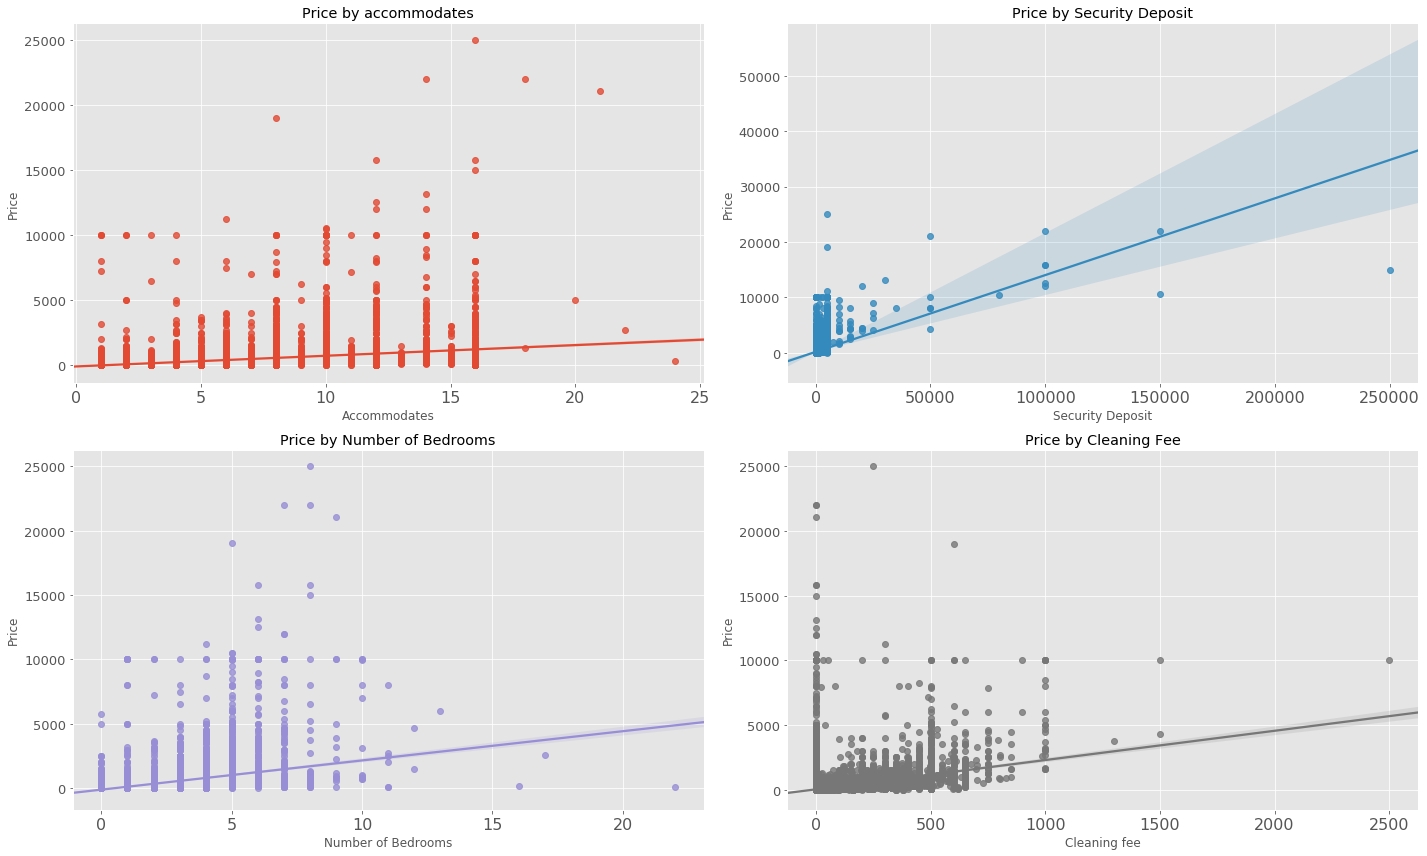

In [18]:
#Visualizing correlation between price and few of the variables

fig, axes = plt.subplots(2, 2, figsize = (20, 12))
ax = sns.regplot(data['accommodates'], data['price'], ax = axes[0][0])
ax.set(title = 'Price by accommodates', xlabel = 'Accommodates', ylabel = 'Price')
ax = sns.regplot(data['security_deposit'], data['price'], ax = axes[0][1])
ax.set(title = 'Price by Security Deposit', xlabel = 'Security Deposit', ylabel = 'Price')
ax = sns.regplot(data['bedrooms'], data['price'], ax = axes[1][0])
ax.set(title = 'Price by Number of Bedrooms', xlabel = 'Number of Bedrooms', ylabel = 'Price')
ax = sns.regplot(data['cleaning_fee'], data['price'], ax = axes[1][1])
ax.set(title = 'Price by Cleaning Fee', xlabel = 'Cleaning fee', ylabel = 'Price')

plt.tight_layout()

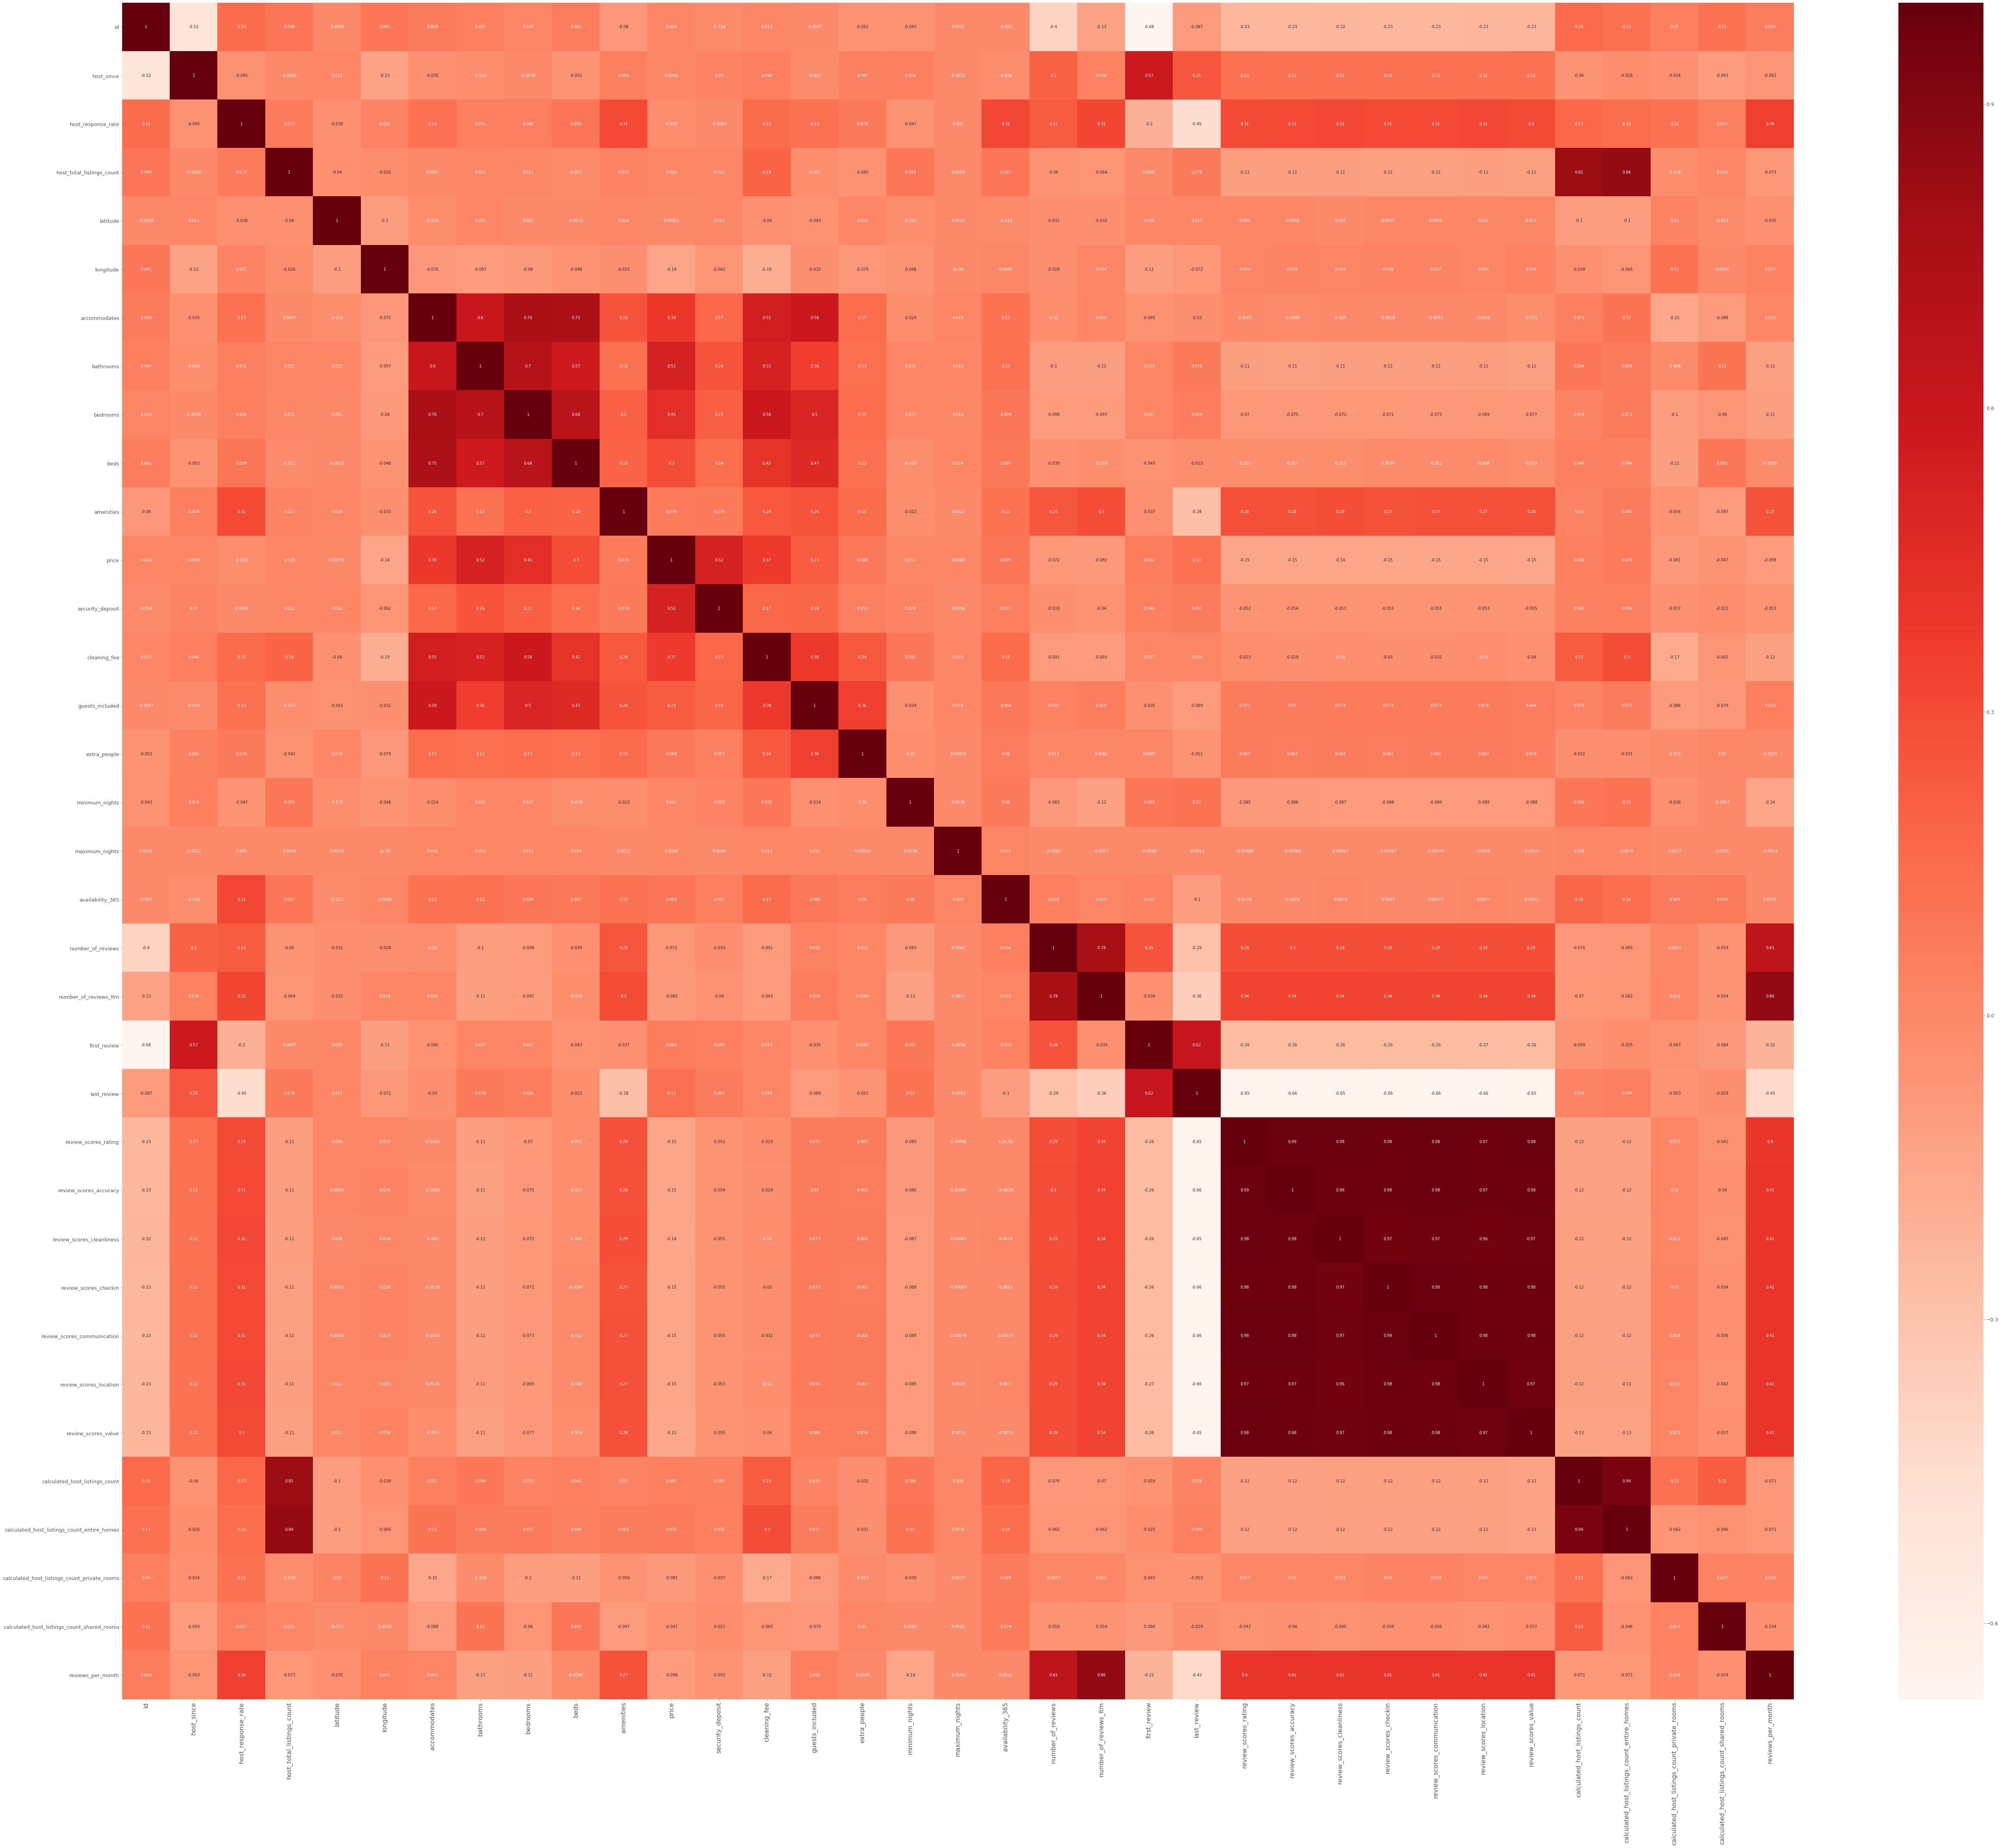

In [19]:
#finding correlation between variables

plt.figure(figsize=(96,80))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [20]:
#Dropping a few correlated variables found from the above heatmap. 

data = data.drop(columns = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                            'review_scores_communication','review_scores_location','calculated_host_listings_count',
                           'last_review','number_of_reviews_ltm']) 
print(data.shape)



(44914, 26)


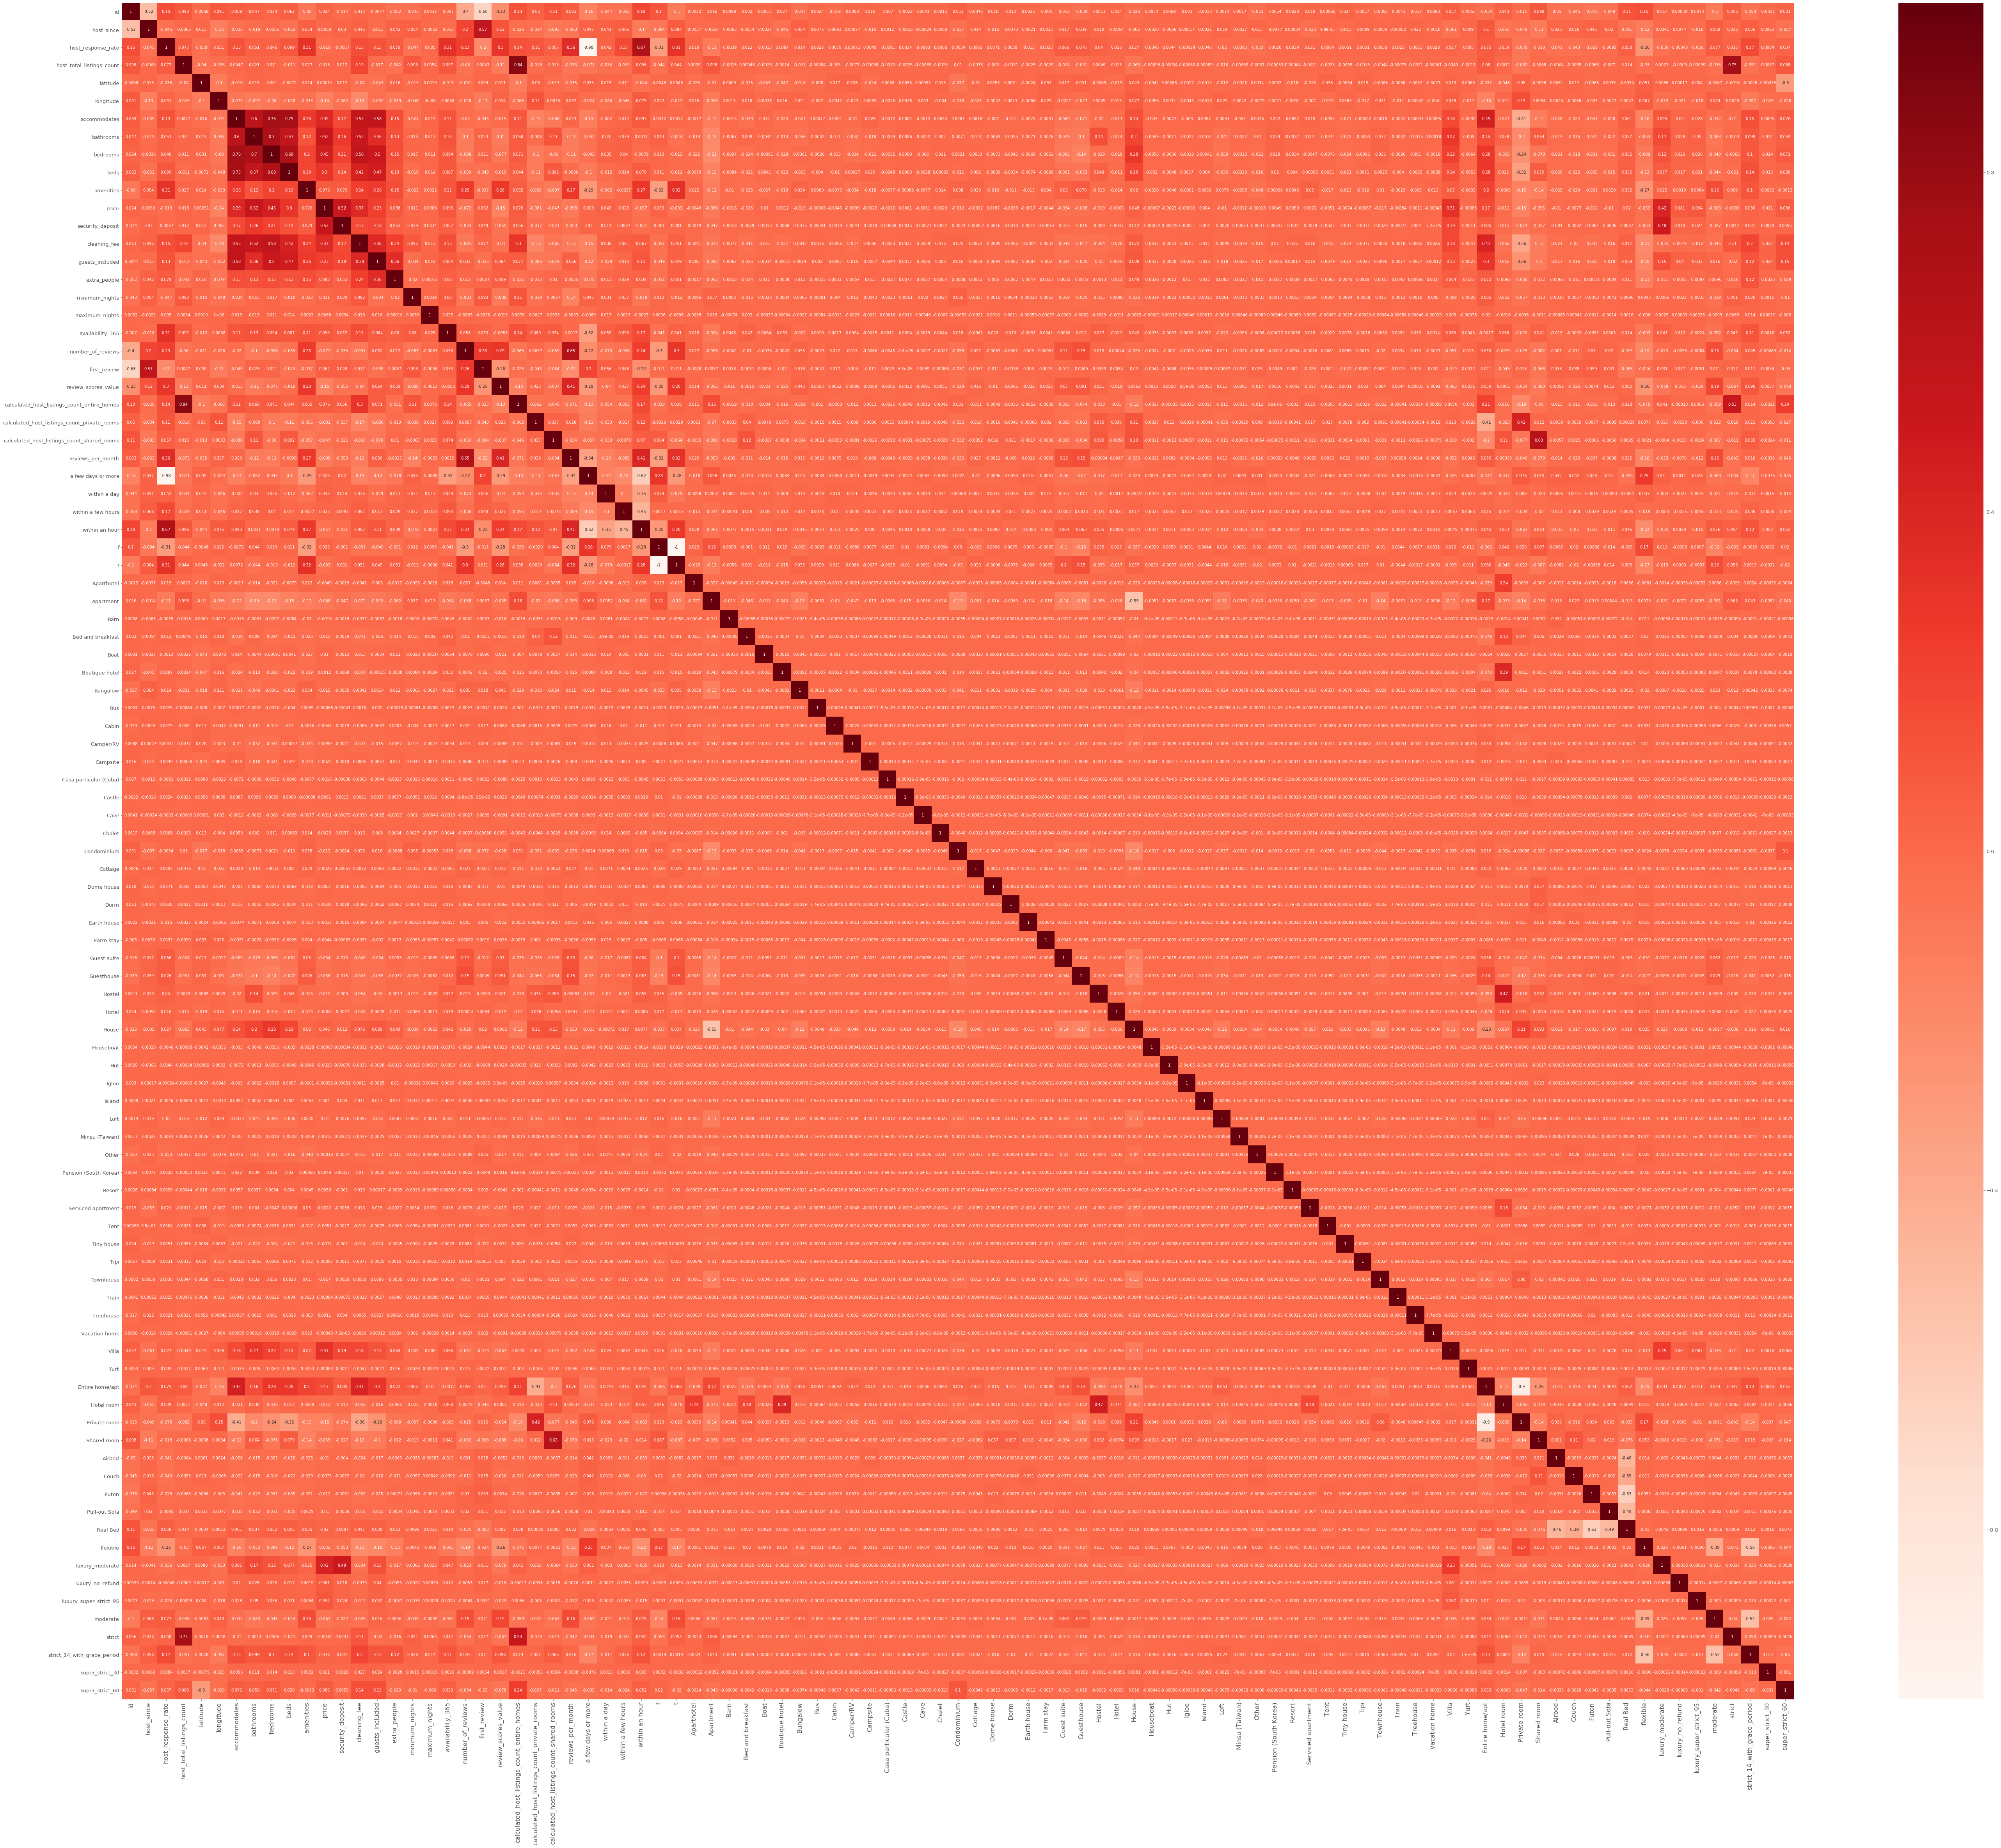

In [21]:
#Concatenating the one-hot representations to the actual dataset
data=pd.concat([data,pd.DataFrame(dummies_host_response_time)],axis=1)
data=pd.concat([data,pd.DataFrame(dummies_host_is_superhost)],axis=1)
data=pd.concat([data,pd.DataFrame(dummies_property_type)],axis=1)
data=pd.concat([data,pd.DataFrame(dummies_room_type)],axis=1)
data=pd.concat([data,pd.DataFrame(dummies_bed_type)],axis=1)
data=pd.concat([data,pd.DataFrame(dummies_cancellation_policy)],axis=1)

##finding correlation between the new variables
plt.figure(figsize=(96,80))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
                                                        

In [22]:
#splitting data into label and predictor varaibles
label = data.loc[:,'price']
final_data = data.drop(columns = ['price'])
print(label.shape)
print(final_data.shape)
final_data.columns

(44914,)
(44914, 94)


Index(['id', 'host_since', 'host_response_rate', 'host_total_listings_count',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review',
       'review_scores_value', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'a few days or more', 'within a day', 'within a few hours',
       'within an hour', 'f', 't', 'Aparthotel', 'Apartment', 'Barn',
       'Bed and breakfast', 'Boat', 'Boutique hotel', 'Bungalow', 'Bus',
       'Cabin', 'Camper/RV', 'Campsite', 'Casa particular (Cuba)', 'Castle',
       'Cave', 'Chalet', 'Condominium', 'Cottage', 'Dome house', 'Dorm',
       'Earth house', 'Farm stay', 'Guest suite', 'Guesthouse', 'Hostel',
  

In [23]:
#splitting data into train and validation and test data
temp_data = final_data.drop(columns = ['latitude','longitude'])
train_data_regression, test_data_regression, train_label_regression, test_label_regression = train_test_split(temp_data,label, test_size = 0.1, random_state = 0)
train_data_regression, validation_data_regression, train_label_regression, validation_label_regression = train_test_split(train_data_regression,train_label_regression, test_size = 0.1, random_state = 0)

print(train_data_regression.shape)
print(validation_data_regression.shape)
print(test_data_regression.shape)
validation_size = validation_data_regression.shape[0]
print(train_label_regression.shape)
print(validation_label_regression.shape)
print(test_label_regression.shape)



(36379, 92)
(4043, 92)
(4492, 92)
(36379,)
(4043,)
(4492,)


In [24]:
#Scaling the data for regression

scaler = StandardScaler().fit(train_data_regression)
train_data_scaled_regression = pd.DataFrame(scaler.transform(train_data_regression))
validation_data_scaled_regression = pd.DataFrame(scaler.transform(validation_data_regression))
test_data_scaled_regression = pd.DataFrame(scaler.transform(test_data_regression))



In [25]:
#Linear Regression using 'Accomodates' as the predictor variable

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,[4]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,[4]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,[6]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-1-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[219.25507188]
Score = 0.1500314519779774
R-Squared = 0.1810427604415689
Adjusted R-Squared = 0.18104276044156886


In [26]:
#Linear Regression using 'Number of reviews' as the predictor variable

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,[16]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,[16]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,[16]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-1-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[-40.48290216]
Score = 0.005114772166665671
R-Squared = 0.005022483354760204
Adjusted R-Squared = 0.005022483354760188


In [27]:
#Multiple linear regression


model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,[1,3,6,7,8,9,10,14,15]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,[1,3,6,7,8,9,10,14,15]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,[1,3,6,7,8,9,10,14,15]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-7-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[-4.81614655e+00 -1.36809438e+01  1.54582491e+02 -6.40865129e+00
 -2.98310052e+01  2.61145535e+02  9.23968300e+01 -1.54782616e-01
  1.75415579e+01]
Score = 0.4263456374479535
R-Squared = 0.32846835769925825
Adjusted R-Squared = 0.32746979763635753


In [28]:
#Multiple linear regression

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14,15,72:90]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14,15,72:90]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14,15,72:90]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-26-1))
#Multiple linear regression
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[ 3.67851819e+00 -1.89438120e+01  1.20232969e+02 -2.33779750e+00
 -2.55690011e+01  1.85555562e+02  1.16841112e+02 -5.83625611e-02
  1.17033039e+01  5.43460982e+01  1.04346087e+00 -9.54365386e+12
 -1.86051354e+12 -9.23489747e+12 -3.83075833e+12 -1.26630741e+13
 -9.99085579e+12 -1.75038224e+13 -1.34111588e+13 -2.72183437e+13
 -1.41644427e+02  1.22406786e+02  3.78139981e+01  2.88105451e+01
 -1.63405309e+02 -2.42109541e+01 -1.84741657e+02]
Score = 0.49899065823870997
R-Squared = 0.34824447099720446
Adjusted R-Squared = 0.3441872279132727


In [29]:
#Multiple linear regression

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14:22]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14:22]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,np.r_[1,3,6,7,8,9,10,14:22]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-13-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[-2.23793003e+00 -1.62137952e+01  1.45673661e+02 -2.02066197e+00
 -1.60911221e+01  2.58281938e+02  9.06616160e+01 -6.77296784e-02
  1.82416220e+01  8.04291074e+00  1.04580350e+00 -5.66826721e+01
 -3.75967967e+00 -7.07977240e+00 -1.12731072e+01]
Score = 0.4355213994832379
R-Squared = 0.3348861173442072
Adjusted R-Squared = 0.33290513779795017


In [30]:
#Multiple linear regression

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,np.r_[72:92]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,np.r_[72:92]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,np.r_[72:92]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1-1))/(validation_size-13-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[ 1.12793073e+02 -4.18675854e-01  1.44172876e+14  2.81061731e+13
  1.39508593e+14  5.78700205e+13 -5.70385090e+12 -4.50019885e+12
 -7.88427768e+12 -6.04081198e+12 -1.22600067e+13 -3.08608776e+14
 -2.73212600e+13 -7.11923444e+12 -7.95943666e+12 -3.00045401e+14
 -4.46488790e+13 -3.36203602e+14 -1.12555696e+13 -4.85544337e+13]
Score = 0.2842834156065034
R-Squared = 0.1858079216281266
Adjusted R-Squared = 0.1833829266069147


In [31]:
#Multiple linear regression


#BEST MODEL


model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,np.r_[4:30,72:90]], y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression.iloc[:,np.r_[4:30,72:90]], y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression.iloc[:,np.r_[4:30,72:90]])
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1))/(validation_size-39-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[ 5.25604798e+01  1.42449438e+02  4.00202605e+01 -3.28830783e+01
 -1.29420607e+01  1.76336692e+02  8.58794769e+01 -4.60027751e+01
  1.68700048e+01 -1.18533471e+01 -1.36426011e-01  1.31441999e+01
  1.51763617e+00  4.68303907e+00 -3.45125368e+01 -2.08271343e+01
 -1.37907095e+01 -2.19960268e+01  1.45224846e+01  5.37186312e+13
  3.45548525e+13  4.30885544e+13  6.50308661e+13 -4.52316241e+13
 -4.52316241e+13  1.60629539e+00  3.96879191e+01  6.53163365e-01
  4.01053199e+13  7.81844057e+12  3.88078321e+13  1.60980051e+13
 -2.98088672e+11 -2.35184672e+11 -4.12039849e+11 -3.15698578e+11
 -6.40719609e+11 -2.01137592e+02  1.11249914e+02  3.61764236e+01
  2.44911232e+01 -2.05094626e+02 -3.31542632e+01 -2.31910651e+02]
Score = 0.53934813710049
R-Squared = 0.4102654949762099
Adjusted R-Squared = 0.40451989275389466


In [32]:
#Multiple linear regression using all variables

model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression, y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression, y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression)
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' +str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1))/(validation_size-92-1))
print('Adjusted R-Squared = ' +str(adjust_R_squared))

[ 9.95179932e+00  3.43926496e+00 -1.14173895e+00  1.58767754e+01
  5.14424628e+01  1.50615192e+02  4.28417376e+01 -3.11239465e+01
 -1.18617361e+01  1.75736925e+02  8.45511816e+01 -4.57079844e+01
  1.69579652e+01 -1.09282447e+01 -2.57581573e-01  1.39032509e+01
  4.23099827e+00  9.29573492e+00 -2.93940340e+01 -3.29574243e+01
 -1.31373787e+01 -2.15675581e+01  1.03663482e+01  3.23504383e+12
  2.08096260e+12  2.59487926e+12  3.91628933e+12 -1.59368180e+13
 -1.59368180e+13  1.43635478e+12  2.14690001e+13  6.16742817e+11
  2.65332947e+12  1.06802429e+12  2.50687309e+12  7.13452248e+12
  3.29685561e+11  1.69597018e+12  2.71364487e+12  7.37118258e+11
  2.33126100e+11  8.40409459e+11 -1.50941582e+01  7.73085523e+11
  1.04808962e+13  2.91479173e+12  7.73085523e+11  4.66232974e+11
  8.40409459e+11  1.01592168e+12  8.10264582e+12  9.89786394e+12
  3.40034208e+12  1.67991740e+12  2.11102598e+13  2.33126100e+11
  4.03775150e+11  2.33126100e+11  3.29685561e+11  6.33482465e+12
  2.33126100e+11  2.46340

In [33]:
#LASSO regression using all variables

model = linear_model.Lasso(alpha = 1)
fitted_model = model.fit(X = train_data_scaled_regression, y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression, y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression)
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
print('R-Squared = ' + str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1))/(validation_size-92-1))
print('Adjusted R-Squared = ' +str (adjust_R_squared))

[ 5.15918302e+00  1.85118834e+00 -2.86116027e+00  1.62112644e+00
  4.70542269e+01  1.49656925e+02  4.09409415e+01 -2.71781618e+01
 -1.01371374e+01  1.75203118e+02  8.30512100e+01 -4.26708579e+01
  1.49718698e+01 -1.00521101e+01 -0.00000000e+00  1.21059371e+01
  2.55167877e+00  6.95794784e+00 -3.02563963e+01 -2.16564109e+01
 -1.20807447e+01 -2.09142549e+01  9.36604776e+00  5.73480700e+00
  1.91253041e+00 -0.00000000e+00 -6.98823838e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.80731472e+00  1.37961508e+00  4.35982916e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  4.16034889e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.79047949e-01
 -1.03636027e+01  0.00000000e+00  8.09666811e+00  0.00000000e+00
  0.00000000e+00 -9.95356498e-02  2.55111960e+00  5.21289087e+00
 -2.22249441e+01  0.00000000e+00 -1.06900116e+01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  3.69497435e-01  1.34396035e+00
 -0.00000000e+00  0.00000

In [34]:
#Elastic Net using all variables

model = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)
fitted_model = model.fit(X = train_data_regression, y = train_label_regression)
print(fitted_model.coef_)
score = fitted_model.score(X = train_data_scaled_regression, y = train_label_regression)
print('Score = ' +str(score))
predicted = fitted_model.predict(X = validation_data_scaled_regression)
corr_coef = np.corrcoef(validation_label_regression,predicted)[1][0]
R_squared = corr_coef**2
print('R-Squared = ' + str(R_squared))
adjust_R_squared = 1 - (((1 - R_squared)*(validation_size-1))/(validation_size-92-1))
print('Adjusted R-Squared = ' +str (adjust_R_squared))


[ 1.36405648e-06 -2.00253755e-03 -5.26305113e-01 -1.22493000e-01
  2.33797519e+01  8.60901261e+01  3.68415903e+01 -6.83240054e+00
 -9.49428553e-01  1.10049564e-01  9.19647716e-01 -8.65790344e+00
  1.62138662e-01 -8.31422365e-01 -1.04520525e-04  1.55975272e-01
  7.69056594e-02  2.23465688e-02 -1.28823182e+01 -1.34016932e-01
 -2.90667055e+00 -5.34322833e+00  1.91588175e+00  0.00000000e+00
  2.03113089e+00  3.67965516e-01 -4.35674839e+00 -4.81108776e-01
  4.81108776e-01  0.00000000e+00 -4.67425379e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -3.41812906e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.48888576e-01  1.49527103e+00
 -6.23336537e-01  0.00000000e+00 -7.59172060e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000

In [36]:
#Classification

#setting a label where 0 means the property isn't really recommended and 1 means otherwise. 

final_data['is_suggested'] = np.where(final_data['review_scores_value'] < 5, 0, 1)
final_data['price'] = data['price']
label = final_data['is_suggested']
temp_data = final_data.drop(columns = ['review_scores_value'])
temp_data = temp_data.drop(columns = ['latitude','longitude','is_suggested'])

temp_data

id  host_since  host_response_rate  host_total_listings_count  \
0           109        4245                 0.0                        1.0   
1           344        4231                50.0                        1.0   
2          2708        4164               100.0                        2.0   
3          2732        4163               100.0                        2.0   
4          2864        4155                 0.0                        1.0   
5          5728        3994               100.0                        8.0   
6          5729        3994               100.0                        8.0   
7          5843        3994               100.0                        8.0   
8          6033        3971               100.0                       14.0   
9          6931        4164               100.0                        2.0   
10         7874        3892               100.0                        3.0   
11         7992        3888               100.0                        2.0   
12         8021        3887               100.0                        1.0   
13         8770        3855               100.0                        1.0   
14         9140        3848               100.0                        1.0   
15         9376        3839               100.0                        2.0   
16        11374        3786               100.0                        2.0   
17        12320        3763               100.0                        1.0   
18        14098        3736               100.0                        7.0   
19        14273        3734               100.0                        1.0   
20        14337        3733               100.0                        2.0   
21        14945        3724               100.0                        1.0   
22        15089        3723               100.0                        2.0   
23        15333        3720               100.0                        2.0   
24        15440        3718               100.0                        1.0   
25        15766        3714               100.0                        1.0   
26        16690        3703               100.0                        2.0   
27        17860        3736                90.0                        5.0   
28        18041        3682                80.0                        3.0   
29        18067        3682                80.0                        3.0   
...         ...         ...                 ...                        ...   
45022  38599129        1984                 0.0                        0.0   
45023  38599248         846               100.0                        9.0   
45024  38599642         150                 0.0                        0.0   
45025  38600128         360                 0.0                        1.0   
45026  38600150        1685                94.0                       15.0   
45027  38600323        1068               100.0                       56.0   
45028  38600344         279                 0.0                        0.0   
45029  38600539        2891               100.0                        7.0   
45030  38600975         195                 0.0                        2.0   
45031  38601442        2169               100.0                        0.0   
45032  38601546         174                 0.0                        0.0   
45033  38601897        2980                 0.0                        1.0   
45034  38602208        2862                 0.0                        0.0   
45035  38602239        1141                92.0                        3.0   
45036  38602450         154                 0.0                        2.0   
45037  38602459         150                 0.0                        1.0   
45038  38602562         667                 0.0                        2.0   
45039  38602647         151                 0.0                        0.0   
45041  38602769        1643                 0.0                        1.0   
45042  38602798        1445        

In [37]:
#splitting data into train, test and validation

train_data_classification, test_data_classification, train_label_classification, test_label_classification = train_test_split(temp_data,label, test_size = 0.1, random_state = 0)
train_data_classification, validation_data_classification, train_label_classification, validation_label_classification = train_test_split(train_data_classification,train_label_classification, test_size = 0.1, random_state = 0)

print(train_data_classification.shape)
print(validation_data_classification.shape)
print(test_data_classification.shape)
print(train_label_classification.shape)
print(validation_label_classification.shape)
print(test_label_classification.shape)


(36379, 92)
(4043, 92)
(4492, 92)
(36379,)
(4043,)
(4492,)


In [38]:
#Scaling the data

scaler = StandardScaler().fit(train_data_classification)
train_data_scaled_classification = pd.DataFrame(scaler.transform(train_data_classification))
validation_data_scaled_classification = pd.DataFrame(scaler.transform(validation_data_classification))
test_data_scaled_classification = pd.DataFrame(scaler.transform(test_data_classification))

[0.8028691565669057, 0.19713084343309428, array([0.        , 0.80286916]), array([0., 1.]), array([0.        , 0.89065715])]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


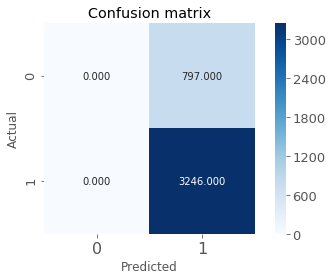

In [39]:
#using the Accomodates variable

classifier = SVC(kernel = 'linear')  
classifier.fit(train_data_scaled_classification.iloc[:,[4]],train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,[4]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8028691565669057, 0.19713084343309428, array([0.        , 0.80286916]), array([0., 1.]), array([0.        , 0.89065715])]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


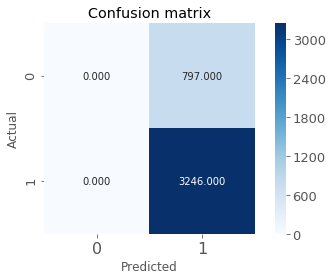

In [40]:
#using the Price variable

classifier = SVC(kernel = 'linear')  
classifier.fit(train_data_scaled_classification.iloc[:,[91]],train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,[91]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.977244620331437, 0.022755379668563003, array([0.95250321, 0.98314951]), array([0.93099122, 0.98860136]), array([0.94162437, 0.9858679 ])]


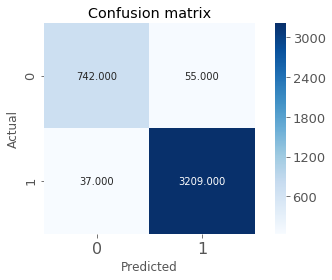

In [41]:
#using all variables and the linear kernel

#BEST MODEL 


classifier = SVC(kernel = 'linear')  
classifier.fit(train_data_scaled_classification,train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification)

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.9537472174128123, 0.04625278258718768, array([0.91327913, 0.96278366]), array([0.84567127, 0.98028343]), array([0.8781759 , 0.97145474])]


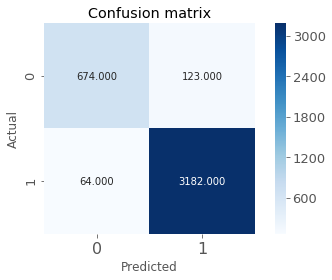

In [42]:
#using all variables and the rbf kernel

classifier = SVC(kernel = 'rbf')  
classifier.fit(train_data_scaled_classification,train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification)

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.9663616126638634, 0.033638387336136555, array([0.89020071, 0.98654568]), array([0.94604768, 0.97134935]), array([0.91727494, 0.97888854])]


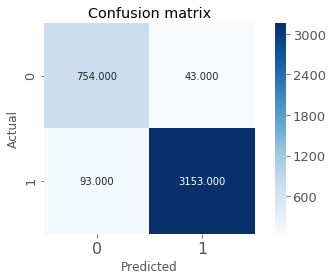

In [43]:
#using multiple predictor variables and linear kernel

classifier = SVC(kernel = 'linear')  
classifier.fit(train_data_scaled_classification.iloc[:,np.r_[4:24,72:91]],train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,np.r_[4:24,72:91]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.7289141726440762, 0.2710858273559238, array([0.24703892, 0.81141367]), array([0.18318695, 0.86290819]), array([0.21037464, 0.83636907])]


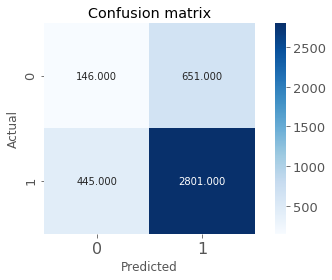

In [44]:
#using KNN with 3 neighbors and one predictor variable

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_data_scaled_classification.iloc[:,[91]],train_label_classification)
predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,[91]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label, average = None)
recall = metrics.recall_score(validation_label_classification, predicted_label, average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8933959930744496, 0.10660400692555039, array([0.76521739, 0.91977334]), array([0.66248432, 0.95009242]), array([0.71015467, 0.93468707])]


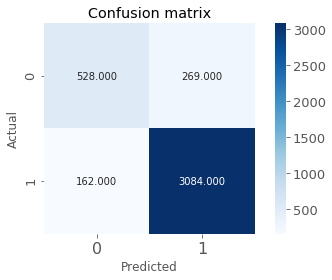

In [45]:
#using KNN with 3 neighbors and all variables

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_data_scaled_classification,train_label_classification)
predicted_label = classifier.predict(validation_data_scaled_classification)

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label, average = None)
recall = metrics.recall_score(validation_label_classification, predicted_label, average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.8929013109077418, 0.10709868909225817, array([0.78706625, 0.91258434]), array([0.62609787, 0.95841035]), array([0.6974144 , 0.93493614])]


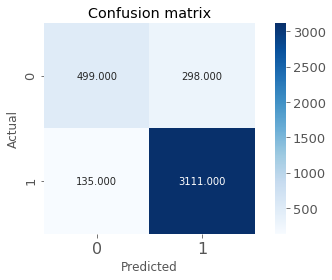

In [46]:
#using KNN with 5 neighbors

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data_scaled_classification,train_label_classification)
predicted_label = classifier.predict(validation_data_scaled_classification)

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label, average = None)
recall = metrics.recall_score(validation_label_classification, predicted_label, average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

[0.864951768488746, 0.135048231511254, array([0.69278034, 0.89799528]), array([0.56587202, 0.93838571]), array([0.62292818, 0.91774631])]


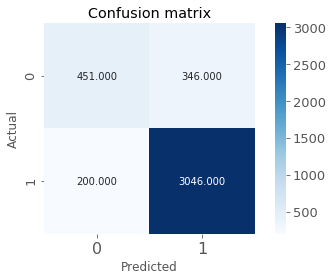

In [47]:
#KNN with 3 neighbors and multiple variables

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_data_scaled_classification.iloc[:,np.r_[4:24,72:91]],train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,np.r_[4:24,72:91]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
#KNN with 3 neighbors and multiple variables
print([accuracy, error, precision, recall, F1_score])

[0.869403907989117, 0.13059609201088296, array([0.72158155, 0.89551804]), array([0.54956085, 0.94793592]), array([0.62393162, 0.92098174])]


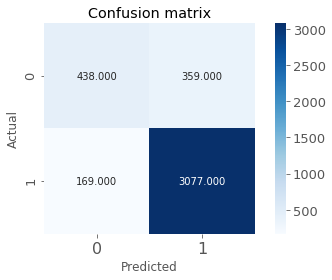

In [48]:
#KNN with 3 neighbors and multiple variables

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data_scaled_classification.iloc[:,np.r_[4:24,72:91]],train_label_classification)

predicted_label = classifier.predict(validation_data_scaled_classification.iloc[:,np.r_[4:24,72:91]])

conf_matrix = metrics.confusion_matrix(validation_label_classification,predicted_label)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(validation_label_classification, predicted_label)
error = 1 - accuracy
precision = metrics.precision_score(validation_label_classification, predicted_label,average= None)
recall = metrics.recall_score(validation_label_classification, predicted_label,average = None)
F1_score = metrics.f1_score(validation_label_classification, predicted_label, average = None)
print([accuracy, error, precision, recall, F1_score])

In [49]:
##PREDICTING ON TEST DATA WITH BEST MDOELS

#regression
model = linear_model.LinearRegression()
fitted_model = model.fit(X = train_data_scaled_regression.iloc[:,np.r_[4:30,72:90]], y = train_label_regression)
predicted = fitted_model.predict(X = test_data_scaled_regression.iloc[:,np.r_[4:30,72:90]])
predicted.shape


(4492,)

In [50]:

#classification
classifier.fit(train_data_scaled_classification,train_label_classification)
predicted_label = classifier.predict(test_data_scaled_classification)
predicted_label.shape

(4492,)

In [51]:
#a dataframe with actual and predicted values

final_output = pd.DataFrame({'Actual Price': test_label_regression,'Predicted Price': predicted,
                             'Actual Is_Suggested':test_label_classification,'Predicted Is_Suggested':predicted_label})

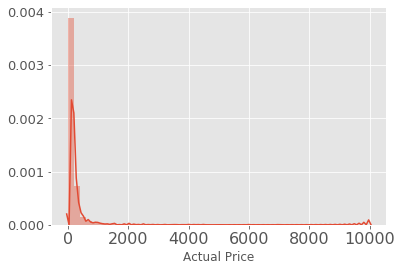

In [52]:
#actual price distribution

x = final_output["Actual Price"]
sns.distplot(x);

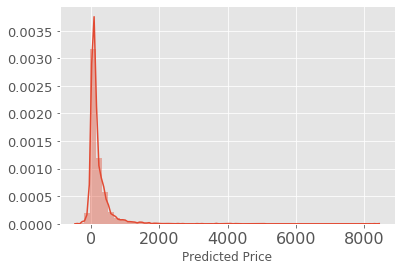

In [53]:
#predicted price distribution

x = final_output["Predicted Price"]
sns.distplot(x);

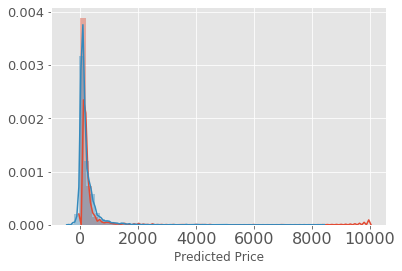

In [54]:
#comparison between the distributions
x = final_output["Actual Price"]
sns.distplot(x);
y = final_output["Predicted Price"]
sns.distplot(y);

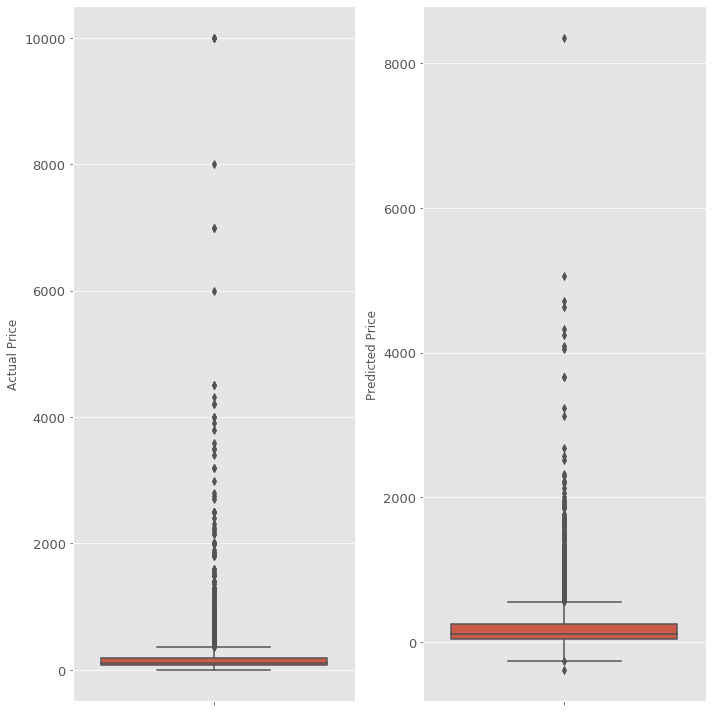

In [55]:
num_columns = 2
fig, axes = plt.subplots(1, 2, figsize = (10, 10))
for i in range(2):
    sns.boxplot(y = final_output.columns[i], data = final_output, orient = 'v', ax = axes[i])
plt.tight_layout()

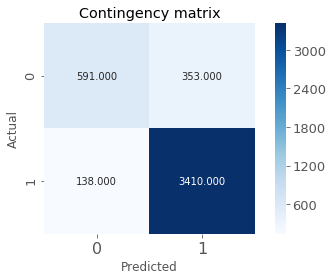

In [56]:
cont_matrix = metrics.cluster.contingency_matrix(final_output['Actual Is_Suggested'],final_output['Predicted Is_Suggested'])
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

In [57]:
final_output['Actual Is_Suggested'] = np.where(final_output['Actual Is_Suggested'] < 1, 'No', 'Yes')
final_output['Predicted Is_Suggested'] = np.where(final_output['Predicted Is_Suggested'] < 1, 'No', 'Yes')

final_output.to_csv("final_output.csv",index=False)